<b>Support vector machines (SVMs)</b> are supervised max-margin models with associated learning algorithms that analyze data for classification and regression analysis.  It tries to find the best boundary known as <i>hyperplane</i> that separates different classes in the data. It is useful when you want to do binary classification like spam vs. not spam or cat vs. dog.

The main goal of SVM is to maximize the margin between the two classes. The larger the margin the better the model performs on new and unseen data.

The popularity of SVMs is likely due to their amenability to theoretical analysis, and their flexibility in being applied to a wide variety of tasks, including structured prediction problems. It is not clear that SVMs have better predictive performance than other linear models, such as logistic regression and linear regression.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
kernels = ['linear', 'rbf', 'poly']

for kernel in kernels:
    print(f"\n--- Kernel: {kernel} ---")
    clf = SVC(kernel=kernel, C=1.0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


--- Kernel: linear ---
[[19  0  0]
 [ 0 12  1]
 [ 0  0 13]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45


--- Kernel: rbf ---
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


--- Kernel: poly ---
[[19  0  0]
 [ 0 13  0]
 [ 0  2 11]]
              precision    recall  f1-score   support

     

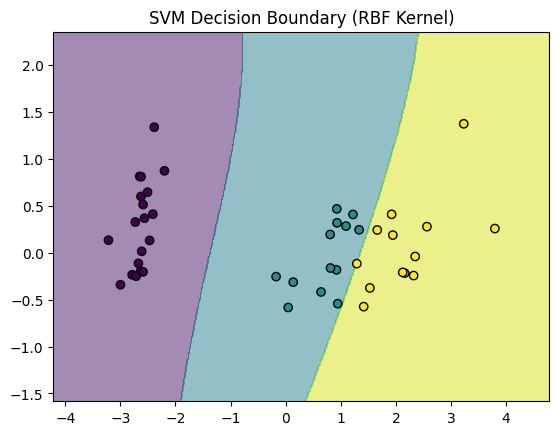

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

clf = SVC(kernel='rbf', C=1.0)
clf.fit(X_train_red, y_train)

def plot_decision_boundary(clf, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title('SVM Decision Boundary (RBF Kernel)')
    plt.show()

plot_decision_boundary(clf, X_test_red, y_test)

Now, let's practice SVM again, this time with SMOTE for imbalanced data and hyperparameter tuning with GridSearchCV

P.S. That's just for practical purposes. SMOTE may be introducing synthetic noise, especially when combined with SVM’s sensitivity to outliers. Without it might be more stable and interpretable boundary, + it is simpler and faster.

class
0    500
1    268
Name: count, dtype: int64


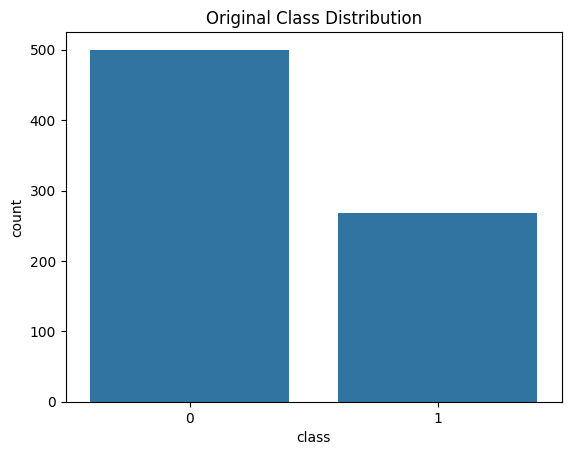

In [8]:
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

df = fetch_openml(name='diabetes', version=1, as_frame=True)['frame']

# Features and label
X = df.drop('class', axis=1)
y = df['class'].map({'tested_negative': 0, 'tested_positive': 1})

# Check class balance
print(y.value_counts())
sns.countplot(x=y)
plt.title('Original Class Distribution')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class
0    350
1    350
Name: count, dtype: int64


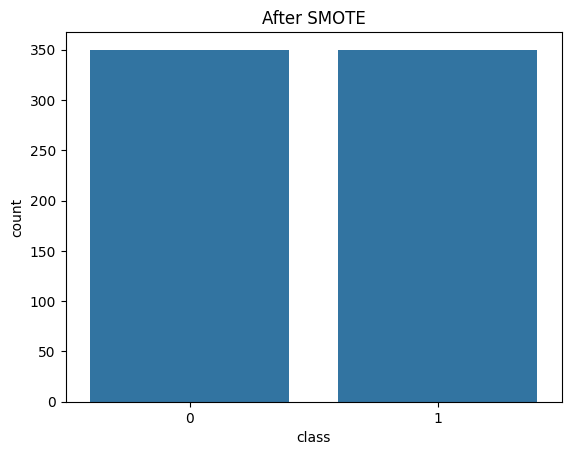

In [10]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print(y_train_bal.value_counts())
sns.countplot(x=y_train_bal)
plt.title('After SMOTE')
plt.show()

In [14]:
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

svc = SVC(class_weight='balanced')
grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1',              # Optional: focus on f1 to improve minority class
    cv=5,
    verbose=1
)

grid.fit(X_train_bal, y_train_bal)

print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [15]:
y_pred = grid.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[125  25]
 [ 42  39]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       150
           1       0.61      0.48      0.54        81

    accuracy                           0.71       231
   macro avg       0.68      0.66      0.66       231
weighted avg       0.70      0.71      0.70       231



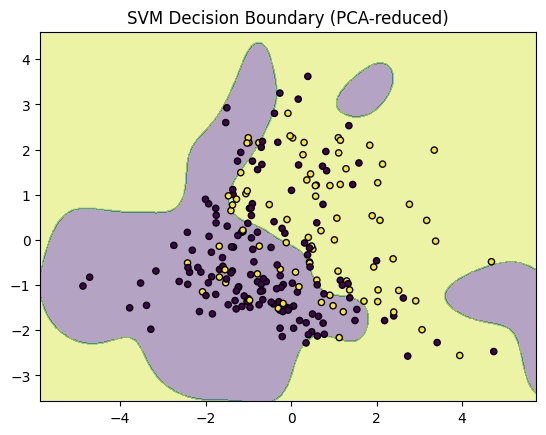

In [16]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca = pca.transform(X_test_scaled)

# Re-train on PCA data for visualization
clf_vis = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], kernel='rbf')
clf_vis.fit(X_train_pca, y_train_bal)

def plot_decision_boundary_svm(clf, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=20)
    plt.title('SVM Decision Boundary (PCA-reduced)')
    plt.show()

plot_decision_boundary_svm(clf_vis, X_test_pca, y_test)